# Extract Specific Analysis Results

This notebook imports the structure saved as pickle file. 
(It has to run in the 'strucenglib3' environment. As it needs compas fea and the strucEngLib to read the pickled object.) it also runs in the sampling environment... warum weis sich nicht

This script reads out specified values form the result dict of each structure of a samiling iteration and saves the results in a df.
This df is then saved as a csv file.

In [2]:
import pickle
import pandas as pd
import os
import json 

C:\Users\kuhnso\AppData\Local\Temp\ipykernel_12144\1277026461.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
#Util functions
def create_folder_if_not_exists(folder_path):
    if not os.path.exists(folder_path):
        try:
            os.makedirs(folder_path)
            print(f"Folder '{folder_path}' created successfully.")
        except OSError as e:
            print(f"Error creating folder '{folder_path}': {e}")

In [4]:
def concrete_bending_verification(structure=None, results = None, step=None, return_type='dict', verbalise=True):

    '''
    This function evaluates the structure results with respect to concrete bending. 
    It caluclates eta based on the ration between the eps_c2d and the calculated eps. Eps here stands for strain.

    Parameters:
    structure: structure object
        a structure object defined after see function ....
    results: dict
        Contains the analysis results for each evaluation step.
    step: string
        the name of the analysis step (e.g. "step_4")
    return type: string
        the type of the return value. Possible return types are dict and df. The default is dict.
    verbalise: bool
        Flag that defines weather the function should print progress information (if set to True) 
        or should run without printing any progress information (if set to False).

    
    Returns:
    res: dict or pandas dataframe
        The function returns a dict with the verification results 
        The dict contains the following keys: 'eta_min_c', 'x_c', 'y_c', 'z_c', 'Location_c', 'GP_count_c'
    '''
    
    # if not results but the structure is given we first extract the results dict from the structure pkl file
    if results == None:
        if structure==None:
            raise Exception("You have not provided a structure of results. You have to provide at one!")
        
        results = structure.results
        if verbalise:
            print('The structure was converted to results dict')

    # save relevant values from dict into a data frame for easyer handling
    df_eps = pd.DataFrame({'eps_1_bot':list(results[step]['GP']['eps_1_bot'].values()),
                         'eps_3_bot':list(results[step]['GP']['eps_3_bot'].values()),
                         'eps_1_top':list(results[step]['GP']['eps_1_top'].values()),
                         'eps_3_top':list(results[step]['GP']['eps_3_top'].values()),
                         'coor_x_sig_sr_1L':list(results[step]['GP']['coor_x_sig_sr_1L'].values()),
                        'coor_y_sig_sr_1L':list(results[step]['GP']['coor_y_sig_sr_1L'].values()),
                         'coor_z_sig_sr_1L':list(results[step]['GP']['coor_z_sig_sr_1L'].values()),
                         } )       


    #define calculation of eta
    def calculate_eta_ifNeg(x):
        if x <0:
            #TODO: incase eps_c2d becomes a variable it has to be included here
            return -0.002/x
        else:
            return None

    # Calculate eta for for each GP an top and bot, for directions 1 and 2 (--> 4 times per GP) 
    df_eps['eta_1_bot']=df_eps['eps_1_bot'].apply(calculate_eta_ifNeg)
    df_eps['eta_3_bot']=df_eps['eps_3_bot'].apply(calculate_eta_ifNeg)
    df_eps['eta_1_top']=df_eps['eps_1_top'].apply(calculate_eta_ifNeg)
    df_eps['eta_3_top']=df_eps['eps_3_top'].apply(calculate_eta_ifNeg)

    # get minimum eta fpr each Gaus Point
    df_eps['eta_min_GP'] = df_eps[['eta_1_bot', 'eta_3_bot', 'eta_1_top', 'eta_3_top']].min(axis=1)
    # Get Minimum eta value of structure
    eta_min_structure = df_eps['eta_min_GP'].min()
    #min_value = df_eps[['eta_1_bot', 'eta_3_bot', 'eta_1_top', 'eta_3_top']].min().min()

    # Find the location (columnname) of the minimum eta value
    location = df_eps[['eta_1_bot', 'eta_3_bot', 'eta_1_top', 'eta_3_top']][df_eps == eta_min_structure].stack().index.tolist()[0][1]
    

    # Getting coordinates of min position
    idx_eta_min_structure = df_eps['eta_min_GP'].idxmin()
    x = df_eps.loc[idx_eta_min_structure, 'coor_x_sig_sr_1L']
    y = df_eps.loc[idx_eta_min_structure, 'coor_y_sig_sr_1L']
    z = df_eps.loc[idx_eta_min_structure, 'coor_z_sig_sr_1L']

    #TODO: At the moment I extract the coordinates of the first reinfoecement layer, x,y coordinate is exactly the same, sonly the z coordinate is a bit off then
    # TODO: find the right z coordinate, then this also includes if it is in top or bottom layer...

    # Count_ mu values smaller than 1
    GP_count= df_eps[df_eps['eta_min_GP'] < 1]['eta_min_GP'].count()


    # write a dict with results and print
    res_concrete={'eta_min_c' : [eta_min_structure], 'x_c' : [x], 'y_c' : [y], 'z_c' : [z], 'Location_c':[location], 'GP_count_c': [GP_count]}

    if return_type=='dict':
        res=res_concrete
    elif return_type=='df':
        res= pd.DataFrame(res_concrete)
    else:
        raise Exception("Only return types dict and df are implemented. Define one of these types.")
    
    return res

In [5]:

def steel_bending_verification(structure=None, results = None, step=None, return_type='dict', verbalise=True):

    '''
    This function evaluates the structure results with respect to reinforcement bending. 
    It caluclates eta based on the ration between the fsu and the stress in the individual reinforcement (sig_sr).

    Parameters:
    structure: structure object
        a structure object defined after see function ....
    results: dict
        Contains the analysis results for each evaluation step.
    step: string
        the name of the analysis step (e.g. "step_4")
    return type: string
        the type of the return value. Possible return types are dict and df. The default is dict.
    verbalise: bool
        Flag that defines weather the function should print progress information (if set to True) 
        or should run without printing any progress information (if set to False).

    
    Returns:
    res: dict or pandas dataframe
        The function returns a dict with the verification results 
        The dict contains the following keys: 'eta_min_s', 'x_s', 'y_s', 'z_s', 'Location_s', 'GP_count_s'
    '''
    
    # if not results but the structure is given we first extract the results dict from the structure pkl file
    if results == None:
        if structure==None:
            raise Exception("You have not provided a structure of results. You have to provide at one!")

        results = structure.results
        if verbalise:
            print('The structure was converted to results dict')

    # extract and calculate steel bending results for a structure
    df_steel = pd.DataFrame({'sig_sr_1L_x':list(results[step]['GP']['sig_sr_1L_x'].values()),
                        'sig_sr_1L_y':list(results[step]['GP']['sig_sr_1L_y'].values()),
                        'sig_sr_2L_x':list(results[step]['GP']['sig_sr_2L_x'].values()),
                        'sig_sr_2L_y':list(results[step]['GP']['sig_sr_2L_y'].values()),
                        'sig_sr_3L_x':list(results[step]['GP']['sig_sr_3L_x'].values()),
                        'sig_sr_3L_y':list(results[step]['GP']['sig_sr_3L_y'].values()),
                        'sig_sr_4L_x':list(results[step]['GP']['sig_sr_4L_x'].values()),
                        'sig_sr_4L_y':list(results[step]['GP']['sig_sr_4L_y'].values()),
                        'coor_x_sig_sr_1L':list(results[step]['GP']['coor_x_sig_sr_1L'].values()),
                        'coor_y_sig_sr_1L':list(results[step]['GP']['coor_y_sig_sr_1L'].values()),
                        'coor_z_sig_sr_1L':list(results[step]['GP']['coor_z_sig_sr_1L'].values()),
               } )


    #define calculation of eta
    def calculate_eta_ifPos(x):
        if x > 0:
            return 720/x #fsu/sig_sr #720 MPa; N/mm2
        #TODO: Get fsu from somewhere (when constant, or when different for different elemens -> Marius will provide a fsu value for each sigma value (for each layer one))
        #TODO: Check for factors that we might need to apply 1.35 to rrgese fsy fsu values??..
        else:
            return None
    
    # Calculate eta for for each GP an top and bot, for directions 1 and 2 (--> 4 times per GP) 
    df_steel['eta_1_x']=df_steel['sig_sr_1L_x'].apply(calculate_eta_ifPos)
    df_steel['eta_1_y']=df_steel['sig_sr_1L_y'].apply(calculate_eta_ifPos)
    df_steel['eta_2_x']=df_steel['sig_sr_2L_x'].apply(calculate_eta_ifPos)
    df_steel['eta_2_y']=df_steel['sig_sr_2L_y'].apply(calculate_eta_ifPos)
    df_steel['eta_3_x']=df_steel['sig_sr_3L_x'].apply(calculate_eta_ifPos)
    df_steel['eta_3_y']=df_steel['sig_sr_3L_y'].apply(calculate_eta_ifPos)
    df_steel['eta_4_x']=df_steel['sig_sr_4L_x'].apply(calculate_eta_ifPos)
    df_steel['eta_4_y']=df_steel['sig_sr_4L_y'].apply(calculate_eta_ifPos)
    
    if verbalise:
        #print number of elements
        print('Number of elements: ',len(df_steel['eta_1_x'])/4)

    # get minimum eta fpr each Gaus Point
    df_steel['eta_min_GP'] = df_steel[['eta_1_x', 'eta_1_y', 'eta_2_x', 'eta_2_y', 'eta_3_x', 'eta_3_y', 'eta_4_x', 'eta_4_y']].min(axis=1)
    # Get Minimum eta value of structure
    eta_min_structure = df_steel['eta_min_GP'].min()

    # Find the location (columnname) of the minimum eta value
    location = df_steel[['eta_1_x', 'eta_1_y', 'eta_2_x', 'eta_2_y', 'eta_3_x', 'eta_3_y', 'eta_4_x', 'eta_4_y']][df_steel == eta_min_structure].stack().index.tolist()[0][1]

    #TODO: include that it is tracked which is the minimum layer 1,2,3 or 4 (to be also predicted)?
    # TODO: one could include all coordinates of all layers and save the right z value than the z bvalue is more accurate!


    # Getting coordinates of min position
    idx_eta_min_structure = df_steel['eta_min_GP'].idxmin()
    x = df_steel.loc[idx_eta_min_structure, 'coor_x_sig_sr_1L']
    y = df_steel.loc[idx_eta_min_structure, 'coor_y_sig_sr_1L']
    z = df_steel.loc[idx_eta_min_structure, 'coor_z_sig_sr_1L']

    # Count_ eta values smaller than 1
    GP_count= df_steel[df_steel['eta_min_GP'] < 1]['eta_min_GP'].count()


    # write a dict with results and print
    res_steel={'eta_min_s' : [eta_min_structure], 'x_s' : [x], 'y_s' : [y], 'z_s' : [z], 'Location_s':[location], 'GP_count_s': [GP_count]}
    if return_type=='dict':
        res=res_steel
    elif return_type=='df':
        res= pd.DataFrame(res_steel)
    else:
        raise Exception("Only return types dict and df are implemented. Define one of these types.")

    return res

In [25]:
def calc_eta(idx_s, start_id, end_id, step, extract_from ='results', folder_name='CFBData', verbalise=True):

    '''
    This function iterates from start_id to end_id. Opens the corresponding file. 
    And calls the result extraction and verification functions for the bending verification.
    It caluclates eta based on the ration between the fsu and the stress in the individual reinforcement (sig_sr).

    Parameters:
    idx_s: integer
        Index of sampling. File identifier.
    start_id: integer
        Structure ID where the function should start iterating.
    end_id: integer
        Structure ID where the function should end iterating.
    step: string
        the name of the analysis step (e.g. "step_4")  
    extract_from: string
        From what type of file should the analysis results be extracted. Possible is "structure" and "results" file.
    folder_name: string
        The name of the folder where the results are located in
    verbalise: bool
        Flag that defines weather the function should print progress information (if set to True) 
        or should run without printing any progress information (if set to False).

    
    Returns:
    df_res: pandas dataframe
        The function returns a dataframe with the verification results combined of all structures from start_id to end_id.
        Each row of the dataframe coresponds to one structure.
    '''

    # Initialize a dictionary to store the extracted data (dict of empty lists)
    df_res=None
    noRes_count=0
    error_count=0
    error_ids=[]
    

    current_directory = os.getcwd()
    folder_path = os.path.join(current_directory, folder_name)

    for ID in range(start_id,end_id+1):
        if verbalise:
            print('ID: ',ID)

        #init no file variable
        nofile=False
        error_flag=False

        #get structure or results file
        if extract_from=='structure':
            if verbalise:
                print("Extracting from structure.pkl file")
            # construct file path
            filepath=folder_path+'\\{}_Batch\\{}_{}_CFB\\{}_{}_structure.pkl'.format(idx_s,idx_s,ID,idx_s,ID)
            #if a structure pickle file exists
            if os.path.exists(filepath):
                with open(filepath, "rb") as pickle_file:
                    srtructure = pickle.load(pickle_file)
                results=srtructure.results
            else: 
                if verbalise:
                    print('The structure.pkl file does not exist: ', filepath)
                nofile=True

        elif extract_from=='results':
            if verbalise:
                print("Extracting from results.json file")
            filepath=folder_path+'\\{}_Batch\\{}_{}_CFB\\{}_{}_analysisResults.json'.format(idx_s,idx_s,ID,idx_s,ID)
            if os.path.exists(filepath):
                with open(filepath, 'r') as file:
                    results = json.load(file)
            else:
                if verbalise:
                    print('The rsults.json file does not exist: ', filepath)
                nofile=True
        else:
            raise Exception("The string given to the extract_from input is invalid. Valid strings are results and structure.")
        
        #if results/ structure file exists
        if not nofile:
            if len(results[step]) >0: 
                if results[step]=='ERROR':
                    error_flag=True
                    if verbalise:
                        print('The rsults.json file exits. However an error happened during the NLFE Analysis.')
                        error_ids.append(ID)
                else:
                    # extract max values from the analysis results of this structre 
                    df_conc=concrete_bending_verification(results=results, step=step, return_type='df', verbalise=verbalise)
                    df_steel=steel_bending_verification(results=results, step=step, return_type='df',verbalise=verbalise)
                    df_c_s=pd.concat([df_steel,df_conc], axis=1)
                    df_c_s['ID']=ID
            else:
                raise Exception("The results/ structure file exists however the defined step is empty. No analysis results can be extracted.")


            if ID==start_id:
                df_res=df_c_s
            else:
                df_res=pd.concat([df_res,df_c_s])

        # if no structure pickle or result json file exists (due to calculation error or simply wrong path)
        if error_flag:
            error_count+=1

            if verbalise:
                print('eta_min_c and eta_min_s are set to 0!')
            res_concrete=pd.DataFrame({'eta_min_c' : [0.], 'x_c' : [None], 'y_c' : [None], 'z_c' : [None], 'Location_c':[None], 'GP_count_c': [None]})
            res_steel=pd.DataFrame({'eta_min_s' : [0.], 'x_s' : [None], 'y_s' : [None], 'z_s' : [None], 'Location_s':None, 'GP_count_s': [None]})
            df_c_s=pd.concat([res_steel,res_concrete], axis=1)
            df_c_s['ID']=ID
            
            if ID==start_id:
                df_res=df_c_s
            else:
                df_res=pd.concat([df_res,df_c_s])
        if nofile:
            print('The results could not extracted, as no results file was available.')
            raise Exception("The results/structure file does not exist. Check the path or rerun the analysis. Path: "+filepath)
    
    print('There were {} Structured that resulted in an error during analysis. (Error IDs: {})'.format(error_count,error_ids))
    return df_res

In [30]:
# Eingabe
idx_s=800
start_id = 0
end_id = 2100
step='step_4'

df_res= calc_eta(idx_s, start_id, end_id, step, extract_from ='results', folder_name='CFBData', verbalise=False)

C:\Users\kuhnso\AppData\Local\Temp\ipykernel_12144\859834828.py:117: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_res=pd.concat([df_res,df_c_s])
C:\Users\kuhnso\AppData\Local\Temp\ipykernel_12144\859834828.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_res=pd.concat([df_res,df_c_s])
C:\Users\kuhnso\AppData\Local\Temp\ipykernel_12144\859834828.py:117: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no 

There were 411 Structured that resulted in an error during analysis. (Error IDs: [])


In [8]:
df_res

,eta_min_s,x_s,y_s,z_s,Location_s,GP_count_s,eta_min_c,x_c,y_c,z_c,Location_c,GP_count_c,ID
0,18.189865,4050.851562,5211.709473,-352.941162,eta_4_x,0,19.147421,8385.604492,1975.996216,-352.941162,eta_3_top,0,0
0,9.099476,225.948547,2506.003662,-352.941162,eta_1_x,0,8.308118,225.948547,1975.996216,-352.941162,eta_3_top,0,1
0,5.107795,225.948547,1975.996216,-352.941162,eta_1_x,0,4.668906,225.948547,2506.003662,-352.941162,eta_3_top,0,2
0,3.983561,225.948547,1975.996216,-352.941162,eta_1_x,0,3.670637,225.948547,1975.996216,-352.941162,eta_3_top,0,3
0,3.572220,225.948547,1975.996216,-352.941162,eta_1_x,0,3.346681,225.948547,1975.996216,-352.941162,eta_3_top,0,4
0,4.059931,225.948547,2506.003662,-352.941162,eta_1_x,0,3.928531,1295.148560,1975.996216,-352.941162,eta_3_top,0,5
0,5.001739,2981.651367,1975.996216,-352.941162,eta_1_x,0,4.457065,2364.348633,2506.003662,-352.941162,eta_3_top,0,6
0,5.282574,4502.748535,1975.996216,-352.941162,eta_1_x,0,4.860826,4502.748535,2506.003662,-352.941162,eta_3_top,0,7
0,3.749961,9487.204102,1975.996216,-352.941162,eta_1_x,0,3.513787,9487.204102,5247.058594,-1071.478027,eta_3_bot,0,8
0,18.189865,4050.851562,5211.709473,-352.941162,eta_4_x,0,19.147421,8385.604492,1975.996216,-352.941162,eta_3_top,0,9


In [29]:
#saving
folder_name='CFBData'
current_directory = os.getcwd()
folder_path = os.path.join(current_directory, folder_name)
filepath=folder_path+'\\{}_Batch\\{}_CFB_evaluations.csv'.format(idx_s,idx_s)

df_res.to_csv(filepath,index=True)

In [30]:
#merge x and y df and save them too
current_directory = os.getcwd()

y_file_name='CFBData\\{}_Batch\\{}_CFB_evaluations.csv'.format(idx_s,idx_s)
y_file_path = os.path.join(current_directory, y_file_name)
df_y=pd.read_csv(y_file_path).drop(columns=['Unnamed: 0'])

x_file_name='CFBData\\{}_Batch\\{}_CFBSamples.csv'.format(idx_s,idx_s)
x_file_path = os.path.join(current_directory, x_file_name)
df_x=pd.read_csv(x_file_path).rename(columns={'Unnamed: 0':'ID'})

df_xy = pd.merge(df_x, df_y, on='ID', how='inner')

filepath=folder_path+'\\{}_Batch\\{}_CFB_xy.csv'.format(idx_s,idx_s)
df_xy.to_csv(filepath,index=True)

df_xy

,ID,L,b1,t_p,t_w,h_w,d1_plate,d4_plate,s_plate,d1_walls,...,y_s,z_s,Location_s,GP_count_s,eta_min_c,x_c,y_c,z_c,Location_c,GP_count_c
0,0,3264.911067,16765.132982,531.656436,621.775968,2604.161687,24.228625,13.427572,206.036846,20.171051,...,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
1,1,5361.115418,17451.415474,744.304389,275.279703,3820.154356,17.838816,12.481430,218.545430,10.168009,...,4987.521973,-2517.141846,eta_1_x,0.0,5.430790,173.859085,98.314178,-4067.336670,eta_3_bot,0.0
2,2,7197.928187,12610.611102,792.070735,496.244565,4273.476243,22.587214,26.028824,128.850732,24.508125,...,6500.823242,-1904.297729,eta_4_x,0.0,18.270001,293.142883,6500.823242,-1090.091309,eta_3_bot,0.0
3,3,4946.728918,16364.414176,373.131286,477.965439,3363.099660,24.607351,29.281128,135.563137,15.921368,...,2073.840576,-326.489868,eta_2_y,0.0,13.517034,3468.395752,2073.840576,-326.489868,eta_3_top,0.0
4,4,4940.337104,19145.252592,464.963852,412.443855,2135.646626,15.313616,16.445258,79.214303,27.700309,...,1656.870605,-425.109802,eta_1_x,0.0,17.884413,3381.489746,2101.281494,-425.109802,eta_3_top,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,3281.367780,15498.452667,577.306324,421.458974,4699.266956,29.736156,27.057742,93.172957,19.072628,...,163.900711,-2296.886475,eta_1_x,0.0,6.351162,1829.632202,163.900711,-4665.050781,eta_3_bot,0.0
996,996,3666.643637,15455.753526,792.299652,471.784421,4931.536191,10.685627,14.709277,194.274833,21.598052,...,2363.356445,-739.479675,eta_3_y,0.0,11.660351,4830.938477,200.508377,-5082.087891,eta_3_bot,0.0
997,997,6184.735919,11369.136905,645.636004,245.825059,3643.241327,28.115256,14.995675,101.134360,22.308382,...,76.088707,-4161.842285,eta_4_x,0.0,9.986733,11232.991211,76.088707,-4161.842285,eta_3_bot,0.0
998,998,7491.926992,9743.524453,776.691431,387.895813,2073.204456,22.060343,17.066350,144.671295,25.435277,...,6957.100586,-921.270569,eta_4_x,0.0,11.777114,8872.617188,6957.100586,-1316.269409,eta_3_bot,0.0


In [66]:
#saving runtimes
n_elements1=[2450.0, 1601.0, 1142.0, 947.0,  947.0, 947.0, 947.0, 947.0, 947.0, 947.0]
analysis_time1=[1052.815,1011.080,649.90,633.543,632.563,637.594,641.200, 650.680, 650.564, 662.114] #seconds
analysis_time1 = [element / 60 for element in analysis_time1] #minutes

n_elements2= [362.0, 257.0,  206.0, 128.0, 128.0, 128.0,  128.0, 128.0,  128.0, 128.]
analysis_time2=[83.119,92.788 ,102.771,84.002,88.768 ,82.442,85.991,87.115, 84.954, 84.954]
analysis_time2 = [element / 60 for element in analysis_time2] #minutes

n_elements3=[2756.0, 1835.0, 1232.0, 1028.0, 1028.0, 1028.0, 1028.0, 1028.0, 1028.0, 1028.0]
analysis_time3=[1107.244,911.303, 570.685, 602.179, 594.138, 591.931, 593.499, 606.966, 603.610, 600.916]
analysis_time3 = [element / 60 for element in analysis_time3] #minutes


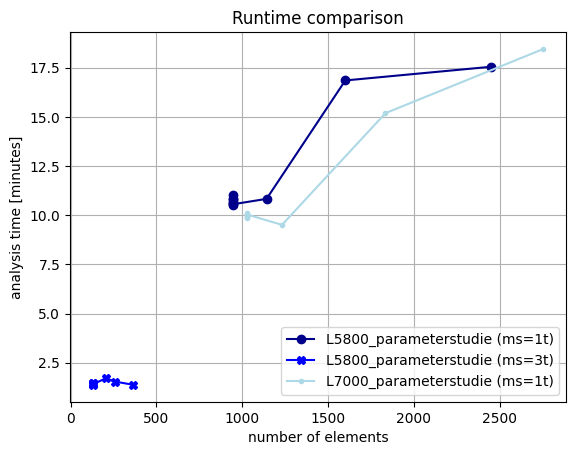

In [69]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(n_elements1, analysis_time1,label='L5800_parameterstudie (ms=1t)', marker='o', color='darkblue')
ax.plot(n_elements2, analysis_time2,label='L5800_parameterstudie (ms=3t)', marker='X', color='blue')
ax.plot(n_elements3, analysis_time3,label='L7000_parameterstudie (ms=1t)', marker='.', color='lightblue')


ax.set(xlabel='number of elements', ylabel='analysis time [minutes]',
       title='Runtime comparison')

# ax.set_ylim(bottom=0,top=20)

ax.grid()
ax.legend()

#fig.savefig("test.png")
plt.show()

## Former Implementation

In [3]:
# def extraction function
# TOdo dont get the max but the absolut max values! or get both min and max
def extract_max_res(structure, ID, step='step_3'):
    # initialise result dict
    max_res={}
    
    #id
    max_res['id'] =ID
    
    #um = total displacements
    max_res['um'] = max(structure.results[step]['nodal']['um'].values())
    #print(max_res['um'])
    
    #ux = displacements
    max_res['ux'] = max(structure.results[step]['nodal']['ux'].values())
    #uy = displacements
    max_res['uy'] = max(structure.results[step]['nodal']['uy'].values())
    #uz = displacements
    max_res['uz'] = max(structure.results[step]['nodal']['uz'].values())

    # sf1 = membrane foces in local x-direction nx
    max_res['sf1'] = max(structure.results[step]['element']['sf1'].values(), key=lambda x: x['ip1_sp0'])['ip1_sp0']
    # sf2 = membrane forces in local y-direction ny
    max_res['sf2'] = max(structure.results[step]['element']['sf2'].values(), key=lambda x: x['ip1_sp0'])['ip1_sp0']
    # sf3 = shear forces in local xy-direction nxy
    max_res['sf3'] = max(structure.results[step]['element']['sf3'].values(), key=lambda x: x['ip1_sp0'])['ip1_sp0']
    # sf4 = transverse shear forces on local x-plane vy
    max_res['sf4'] = max(structure.results[step]['element']['sf4'].values(), key=lambda x: x['ip1_sp0'])['ip1_sp0']
    # sf5 = transverse shear forces on local y-plane vx
    max_res['sf5'] = max(structure.results[step]['element']['sf5'].values(), key=lambda x: x['ip1_sp0'])['ip1_sp0']
    # sm1 = bending moments around local y-direction m_x
    max_res['sm1'] = max(structure.results[step]['element']['sm1'].values(), key=lambda x: x['ip1_sp0'])['ip1_sp0']
    # sm2 = bending moments around local x-direction m_y
    max_res['sm2'] = max(structure.results[step]['element']['sm2'].values(), key=lambda x: x['ip1_sp0'])['ip1_sp0']
    # sm3 = twisting moments in x- and y-directions m_xy
    max_res['sm3'] = max(structure.results[step]['element']['sm3'].values(), key=lambda x: x['ip1_sp0'])['ip1_sp0']
    
    
    # Sig_x_top = membran spannung in x richtung
    #max_res['sig_x_top'] = max(structure.results['step_2']['sig_x_top'].values(), key=lambda x: x['ip1_sp0'])['ip1_sp0']
    
    return max_res

In [4]:
# Eingabe
idx_s=1
start_id = 0
end_id = 0
step='step_3'

In [5]:
y_names=['id','um','ux', 'uy', 'uz', 'sf1', 'sf2', 'sf3', 'sf4', 'sf5', 'sm1', 'sm2', 'sm3','analysis_error']

# Initialize a dictionary to store the extracted data (dict of empty lists)
y_dict = {param: [] for param in y_names}
errors=[]
noResults=[]

current_directory = os.getcwd()
folder_name='CFBData'
folder_path = os.path.join(current_directory, folder_name)

for ID in range(start_id,end_id+1):
    print(ID)
    
    # construct file path
    filepath=folder_path+'\\{}_Batch\\{}_{}_CFB\\{}_{}_structure.pkl'.format(idx_s,idx_s,ID,idx_s,ID)
    
    if os.path.exists(filepath): # if structure.pkl exists for this ID
        # get structure
        with open(filepath, "rb") as pickle_file:
            structure = pickle.load(pickle_file)

        if len(structure.results[step]) >0: 
            # extract max values from the analysis results of this structre 
            max_res=extract_max_res(structure, ID, step=step)

            #save max results from current structure in results dict
            for y in y_names[:-1]:
                y_dict[y].append(max_res[y])
            # error handling 
            #(TODO: better error handling would be why it failed - written in error file by ansys)
            # TODO: also should not stop analysis when analysis failes!
            y_dict['analysis_error'].append(False)
            
            
        else:
            noResults.append('{}_{}'.format(idx_s, ID))

#             for y in y_names[:-2]:
#                 y_dict[y].append(None)
            
#         y_dict['noresults'].append(True)
#         y_dict['analysis_error'].append(False)
    
    else:
        
        #structure.pkl file does not exist for this does not exist for this ID
        for y in y_names[1:-1]:
                y_dict[y].append(None)
        
        y_dict['id'].append(ID)
        y_dict['analysis_error'].append(True)
        
        errors.append('{}_{}'.format(idx_s, ID))


print(y_dict)
            
y_df=pd.DataFrame.from_dict(y_dict)
    

0




-------------------------------------------------------------
-------------------------------------------------------------
Start new STRUCENG Library Analysis, 21/12/2023 09:36:02
-------------------------------------------------------------
-------------------------------------------------------------


Translate Rhino file into the Structure object
--------------------------------------------------------


KeyError: 'element'

In [7]:
# save df to csv
path =folder_path+'\\{}_Batch\\{}_SumRes.csv'.format(idx_s,idx_s)
y_df.to_csv(path,index=True) # Save csv file

#TODO also save individual y results in the individual folders! y.csv like x.csv

In [8]:
#look at errors
noResults

['1_0']

In [9]:
#look at errors
errors

[]

In [10]:
y_df

,id,um,ux,uy,uz,sf1,sf2,sf3,sf4,sf5,sm1,sm2,sm3,analysis_error


# Beton Nachwei implementiern

In [32]:
idx_s=1
ID =0# construct file path
filepath=folder_path+'\\{}_Batch\\{}_{}_CFB\\{}_{}_structure.pkl'.format(idx_s,idx_s,ID,idx_s,ID)
    
    
if os.path.exists(filepath):
    # get structure
    with open(filepath, "rb") as pickle_file:
        structure = pickle.load(pickle_file)
else:
    print('File ',filepath, 'does not exist.')

In [55]:
list(structure.elements.keys())[-1]*4

508

In [57]:
list(structure.results['step_3']['GP']['eps_1_bot'].keys())[-1]

511

In [ ]:
structure.results['step_3']['GP'].keys()
# 'elem_nr_top', 'sig_y_bot', 'elem_nr_1L', 'elem_typ', 'elem_nr_2L', 'loc_y_glob_y', 'elem_nr_3L', 'elem_nr_4L', 'eps_3_bot', 
# 'GP_name_top', 'loc_x_glob_x', 'sig_sr_1L_y', 'sig_sr_1L_x', 'coor_intp_layer_x_bot', 'coor_x_sig_sr_4L', 'coor_x_sig_sr_1L', 'coor_x_sig_sr_3L', 
# 'coor_x_sig_sr_2L', 'eps_1_top', 'tau_xy_top', 'coor_intp_layer_y_bot', 'nr', 'loc_x_glob_z', 'fcc_eff_bot', 'sig_x_top', 'coor_z_sig_sr_4L', 'coor_intp_layer_z_bot', 
# 'tau_xy_bot', 'coor_z_sig_sr_1L', 'loc_y_glob_x', 'coor_z_sig_sr_2L', 'coor_z_sig_sr_3L', 'sig_y_top', 'GP_name_1L', 'GP_name_3L', 'eps_3_top', 'GP_name_2L', 'sig_sr_3L_y', 
# 'sig_sr_3L_x', 'GP_name_4L', 'sig_sr_4L_x', 'sig_sr_4L_y', 'GP_name_bot', 'elem_nr_bot', 'sig_sr_2L_y', 'sig_sr_2L_x', 'loc_y_glob_z', 'loc_x_glob_y', 'coor_intp_layer_x_top',
# 'fcc_eff_top', 'eps_1_bot', 'coor_intp_layer_y_top', 'coor_y_sig_sr_4L', 'coor_y_sig_sr_1L', 'coor_y_sig_sr_3L', 'coor_intp_layer_z_top', 'sig_x_bot', 'coor_y_sig_sr_2L'


'eps_3_bot','eps_1_top','eps_3_top','eps_1_bot'

'coor_x_sig_sr_4L', 'coor_x_sig_sr_1L', 'coor_x_sig_sr_3L', 'coor_x_sig_sr_2L' 
'coor_y_sig_sr_4L', 'coor_y_sig_sr_1L', 'coor_y_sig_sr_3L', 'coor_y_sig_sr_2L'
'coor_z_sig_sr_4L','coor_z_sig_sr_1L', 'coor_z_sig_sr_3L','coor_z_sig_sr_2L',

'coor_x_sig_sr_1L', 'coor_y_sig_sr_1L', 'coor_z_sig_sr_1L',


'sig_sr_1L_y', 'sig_sr_1L_x',
'sig_sr_3L_y', 'sig_sr_3L_x',
'sig_sr_4L_x', 'sig_sr_4L_y',
'sig_sr_2L_y', 'sig_sr_2L_x',

In [70]:
import numpy as np
import pandas as pd

In [ ]:
df_eps['mu_min_GP']

In [75]:
# # To Safe in one df for each strcuture
# um_max
# mu_min_concrete_structure
# count_GPs_mu_concrete_smaller_1
# x_vom min GP
# y_vom min GP
# z_vom min GP
# mu_min Steel_bending
# count_GPs_mu_smaller_1
# count_GPs_mu_steel_smaller_1

In [113]:
structure.results['step_3']['GP']['coor_x_sig_sr_1L']

{0: 225.94854736328125,
 1: 843.25146484375,
 2: 225.94854736328125,
 3: 843.25146484375,
 4: 1295.1485595703125,
 5: 1912.451416015625,
 6: 1295.1485595703125,
 7: 1912.451416015625,
 8: 2364.3486328125,
 9: 2981.6513671875,
 10: 2364.3486328125,
 11: 2981.6513671875,
 12: 225.94854736328125,
 13: 843.25146484375,
 14: 225.94854736328125,
 15: 843.25146484375,
 16: 1295.1485595703125,
 17: 1912.451416015625,
 18: 1295.1485595703125,
 19: 1912.451416015625,
 20: 2364.3486328125,
 21: 2981.6513671875,
 22: 2364.3486328125,
 23: 2981.6513671875,
 24: 225.94854736328125,
 25: 843.25146484375,
 26: 225.94854736328125,
 27: 843.25146484375,
 28: 1295.1485595703125,
 29: 1912.451416015625,
 30: 1295.1485595703125,
 31: 1912.451416015625,
 32: 2364.3486328125,
 33: 2981.6513671875,
 34: 2364.3486328125,
 35: 2981.6513671875,
 36: 225.94854736328125,
 37: 843.25146484375,
 38: 225.94854736328125,
 39: 843.25146484375,
 40: 1295.1485595703125,
 41: 1912.451416015625,
 42: 1295.1485595703125,
 4

In [119]:
df_eps

,eps_1_bot,eps_3_bot,eps_1_top,eps_3_top,coor_x_sig_sr_1L,coor_y_sig_sr_1L,coor_y_sig_sr_2L,coor_z_sig_sr_1L,coor_z_sig_sr_2L,mu_1_bot,mu_3_bot,mu_1_top,mu_3_top,mu_min_GP
0,1.824175e-07,-0.000046,0.000052,-0.000001,225.948547,188.290451,188.290451,-352.941162,-329.411774,NaN,43.381242,NaN,1950.858021,43.381242
1,2.138498e-07,-0.000045,0.000050,-0.000001,843.251465,188.290451,188.290451,-352.941162,-329.411774,NaN,44.722293,NaN,1658.134575,44.722293
2,9.693066e-07,-0.000046,0.000053,-0.000002,225.948547,702.709534,702.709534,-352.941162,-329.411774,NaN,43.393521,NaN,1231.120399,43.393521
3,1.005851e-06,-0.000045,0.000050,-0.000002,843.251465,702.709534,702.709534,-352.941162,-329.411774,NaN,44.730226,NaN,1086.699106,44.730226
4,5.518278e-07,-0.000043,0.000047,-0.000005,1295.148560,188.290451,188.290451,-352.941162,-329.411774,NaN,46.053360,NaN,420.198926,46.053360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
508,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
509,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
510,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN


In [124]:
# extract and calculate concret bedning results for a structure

# save relevant values from dict into a data frame for easyer handling
df_eps = pd.DataFrame({'eps_1_bot':list(structure.results['step_3']['GP']['eps_1_bot'].values()),
              'eps_3_bot':list(structure.results['step_3']['GP']['eps_3_bot'].values()),
              'eps_1_top':list(structure.results['step_3']['GP']['eps_1_top'].values()),
              'eps_3_top':list(structure.results['step_3']['GP']['eps_3_top'].values()),
              'coor_x_sig_sr_1L':list(structure.results['step_3']['GP']['coor_x_sig_sr_1L'].values()),
              'coor_y_sig_sr_1L':list(structure.results['step_3']['GP']['coor_y_sig_sr_1L'].values()),
              'coor_z_sig_sr_1L':list(structure.results['step_3']['GP']['coor_z_sig_sr_1L'].values()),
               } )

#define calculation of mu
def calculate_mu_ifNeg(x):
    if x <0:
        return -0.002/x
    else:
        return None

# Calculate mu for for each GP an top and bot, for directions 1 and 2 (--> 4 times per GP) 
df_eps['mu_1_bot']=df_eps['eps_1_bot'].apply(calculate_mu_ifNeg)
df_eps['mu_3_bot']=df_eps['eps_3_bot'].apply(calculate_mu_ifNeg)
df_eps['mu_1_top']=df_eps['eps_1_top'].apply(calculate_mu_ifNeg)
df_eps['mu_3_top']=df_eps['eps_3_top'].apply(calculate_mu_ifNeg)

# get minimum mu fpr each Gaus Point
df_eps['mu_min_GP'] = df_eps[['mu_1_bot', 'mu_3_bot', 'mu_1_top', 'mu_3_top']].min(axis=1)

# Get Minimum mu value of structure
mu_min_structure = df_eps['mu_min_GP'].min()

#TODO: include top or bottom is tracked?


# Getting coordinates of min position
idx_mu_min_structure = df_eps['mu_min_GP'].idxmin()
x = df_eps.loc[idx_mu_min_structure, 'coor_x_sig_sr_1L']
y = df_eps.loc[idx_mu_min_structure, 'coor_y_sig_sr_1L']
z = df_eps.loc[idx_mu_min_structure, 'coor_z_sig_sr_1L']

#TODO: At the moment I extract the coordinates of the first reinfoecement layer, x,y coordinate is exactly the same, sonly the z coordinate is a bit off then
# TODO: find the right z coordinate, then this also includes if it is in top or bottom layer...

# Count_ mu values smaller than 1
GP_count= df_eps[df_eps['mu_min_GP'] < 1]['mu_min_GP'].count()


# write a dict with results and print
res_concrete={'mu_min' : mu_min_structure, 'x' : x, 'y' : y, 'z' : z, 'GP_count': GP_count}
print(res_concrete)

# df_eps

{'mu_min': 19.99099401654695, 'x': 225.94854736328125, 'y': 152.94117736816406, 'z': -2308.52197265625, 'GP_count': 0}


In [137]:
# extract and calculate steel bending results for a structure
df_steel = pd.DataFrame({'sig_sr_1L_x':list(structure.results['step_3']['GP']['sig_sr_1L_x'].values()),
                        'sig_sr_1L_y':list(structure.results['step_3']['GP']['sig_sr_1L_y'].values()),
                        'sig_sr_2L_x':list(structure.results['step_3']['GP']['sig_sr_2L_x'].values()),
                        'sig_sr_2L_y':list(structure.results['step_3']['GP']['sig_sr_2L_y'].values()),
                        'sig_sr_3L_x':list(structure.results['step_3']['GP']['sig_sr_3L_x'].values()),
                        'sig_sr_3L_y':list(structure.results['step_3']['GP']['sig_sr_3L_y'].values()),
                        'sig_sr_4L_x':list(structure.results['step_3']['GP']['sig_sr_4L_x'].values()),
                        'sig_sr_4L_y':list(structure.results['step_3']['GP']['sig_sr_4L_y'].values()),
                        'coor_x_sig_sr_1L':list(structure.results['step_3']['GP']['coor_x_sig_sr_1L'].values()),
                        'coor_y_sig_sr_1L':list(structure.results['step_3']['GP']['coor_y_sig_sr_1L'].values()),
                        'coor_z_sig_sr_1L':list(structure.results['step_3']['GP']['coor_z_sig_sr_1L'].values()),
               } )


#define calculation of mu
def calculate_mu_ifPos(x):
    if x > 0:
        return 720/x #fsu/sig_sr #720 MPa; N/mm2
    #TODO: Get fsu from somewhere (when constant, or when different for different elemens -> Marius will provide a fsu value for each sigma value (for each layer one))
    #TODO: Check the units of sig output from anys, if this is really N/mm2
    #TODO: Check for factors that we might need to apply 1.35 to rrgese fsy fsu values??..
    else:
        return None
    
# Calculate mu for for each GP an top and bot, for directions 1 and 2 (--> 4 times per GP) 
df_steel['mu_1_x']=df_steel['sig_sr_1L_x'].apply(calculate_mu_ifPos)
df_steel['mu_1_y']=df_steel['sig_sr_1L_y'].apply(calculate_mu_ifPos)
df_steel['mu_2_x']=df_steel['sig_sr_2L_x'].apply(calculate_mu_ifPos)
df_steel['mu_2_y']=df_steel['sig_sr_2L_y'].apply(calculate_mu_ifPos)
df_steel['mu_3_x']=df_steel['sig_sr_3L_x'].apply(calculate_mu_ifPos)
df_steel['mu_3_y']=df_steel['sig_sr_3L_y'].apply(calculate_mu_ifPos)
df_steel['mu_4_x']=df_steel['sig_sr_4L_x'].apply(calculate_mu_ifPos)
df_steel['mu_4_y']=df_steel['sig_sr_4L_y'].apply(calculate_mu_ifPos)

# get minimum mu fpr each Gaus Point
df_steel['mu_min_GP'] = df_steel[['mu_1_x', 'mu_1_y', 'mu_2_x', 'mu_2_y', 'mu_3_x', 'mu_3_y', 'mu_4_x', 'mu_4_y']].min(axis=1)


# Get Minimum mu value of structure
mu_min_structure = df_steel['mu_min_GP'].min()

#TODO: include that it is tracked which is the minimum layer 1,2,3 or 4 (to be also predicted)?
# TODO: one could include all coordinates of all layers and save the right z value than the z bvalue is more accurate!


# Getting coordinates of min position
idx_mu_min_structure = df_steel['mu_min_GP'].idxmin()
x = df_steel.loc[idx_mu_min_structure, 'coor_x_sig_sr_1L']
y = df_steel.loc[idx_mu_min_structure, 'coor_y_sig_sr_1L']
z = df_steel.loc[idx_mu_min_structure, 'coor_z_sig_sr_1L']

# Count_ mu values smaller than 1
GP_count= df_steel[df_steel['mu_min_GP'] < 1]['mu_min_GP'].count()


# write a dict with results and print
res_steel={'mu_min' : mu_min_structure, 'x' : x, 'y' : y, 'z' : z, 'GP_count': GP_count}
print(res_steel)

df_steel

{'mu_min': 20.108432560451167, 'x': 225.94854736328125, 'y': 1975.9962158203125, 'z': -352.941162109375, 'GP_count': 0}


,sig_sr_1L_x,sig_sr_1L_y,sig_sr_2L_x,sig_sr_2L_y,sig_sr_3L_x,sig_sr_3L_y,sig_sr_4L_x,sig_sr_4L_y,coor_x_sig_sr_1L,coor_y_sig_sr_1L,coor_z_sig_sr_1L,mu_1_x,mu_1_y,mu_2_x,mu_2_y,mu_3_x,mu_3_y,mu_4_x,mu_4_y,mu_min_GP
0,-7.446868,0.0,0.0,0.590494,0.0,1.269858,23.815334,0.0,225.948547,188.290451,-352.941162,NaN,None,None,1219.317618,None,566.992688,30.232622,None,30.232622
1,-7.241235,0.0,0.0,0.632908,0.0,1.309648,22.923134,0.0,843.251465,188.290451,-352.941162,NaN,None,None,1137.606443,None,549.766079,31.409318,None,31.409318
2,-7.436198,0.0,0.0,2.807500,0.0,1.093548,23.817223,0.0,225.948547,702.709534,-352.941162,NaN,None,None,256.455932,None,658.407062,30.230225,None,30.230225
3,-7.230566,0.0,0.0,2.839449,0.0,1.134096,22.932243,0.0,843.251465,702.709534,-352.941162,NaN,None,None,253.570351,None,634.867075,31.396841,None,31.396841
4,-7.004004,0.0,0.0,-0.059413,0.0,-0.539510,22.224894,0.0,1295.148560,188.290451,-352.941162,NaN,None,None,NaN,None,NaN,32.396106,None,32.396106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,NaN,None,None,NaN,None,NaN,NaN,None,NaN
508,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,NaN,None,None,NaN,None,NaN,NaN,None,NaN
509,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,NaN,None,None,NaN,None,NaN,NaN,None,NaN
510,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,NaN,None,None,NaN,None,NaN,NaN,None,NaN


In [90]:
np.array(list(structure.results['step_3']['GP']['eps_3_bot'].values()))

array([-4.61028758e-05, -4.47204256e-05, -4.60898300e-05, -4.47124949e-05,
       -4.34278845e-05, -4.07282132e-05, -4.34450958e-05, -4.07585685e-05,
       -3.90425957e-05, -3.61179118e-05, -3.92069705e-05, -3.63041327e-05,
       -1.57607553e-06, -1.92052198e-06, -5.55958877e-07, -8.75414685e-07,
       -1.08727670e-06, -1.77113623e-06,  6.95536244e-07,  2.45982026e-08,
       -2.45838692e-06, -2.90662661e-06, -1.59703302e-06, -1.98604198e-06,
       -2.29521834e-06, -2.60853858e-06, -2.79689152e-06, -3.10623955e-06,
       -3.21873063e-06, -3.79405310e-06, -4.13238149e-06, -4.68705321e-06,
       -4.98461441e-06, -5.12220913e-06, -5.27927659e-06, -5.41631516e-06,
       -4.90185121e-05, -4.70925188e-05, -4.90471102e-05, -4.71153144e-05,
       -4.55031186e-05, -4.28076564e-05, -4.54803121e-05, -4.27704144e-05,
       -4.08307351e-05, -3.75679083e-05, -4.07275038e-05, -3.74352858e-05,
       -3.39304170e-05, -3.39535181e-05, -3.11046315e-05, -3.11395925e-05,
       -2.83782119e-05, -

In [58]:
for GP in structure.results['step_3']['GP']['eps_1_bot'].keys():
    print(structure.results['step_3']['GP']['eps_1_bot'][GP]<0)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
False
False
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fa

In [38]:
structure.results['step_3']['GP']['eps_1_bot']
structure.results['step_3']['GP']['eps_3_bot']
structure.results['step_3']['GP']['eps_1_top']
structure.results['step_3']['GP']['eps_3_top']

{0: -1.0251899311697343e-06,
 1: -1.2061747156622005e-06,
 2: -1.6245364804490237e-06,
 3: -1.8404358570478507e-06,
 4: -4.759650437335949e-06,
 5: -4.978164724889211e-06,
 6: -5.116094598633936e-06,
 7: -5.424715709523298e-06,
 8: -3.755556235773838e-06,
 9: -3.961541096941801e-06,
 10: -4.129119588469621e-06,
 11: -4.4709140638588e-06,
 12: -3.562207712093368e-05,
 13: -3.4441560273990035e-05,
 14: -3.5591263440437615e-05,
 15: -3.439859574427828e-05,
 16: -3.3450545743107796e-05,
 17: -3.1278017559088767e-05,
 18: -3.331508196424693e-05,
 19: -3.110092075075954e-05,
 20: -2.9881954105803743e-05,
 21: -2.728270374063868e-05,
 22: -2.968845728901215e-05,
 23: -2.7059310014010407e-05,
 24: -2.5377710699103773e-05,
 25: -2.521686110412702e-05,
 26: -2.5406998247490264e-05,
 27: -2.5248766178265214e-05,
 28: -2.536290958232712e-05,
 29: -2.5122062652371824e-05,
 30: -2.5367307898704894e-05,
 31: -2.512491846573539e-05,
 32: -2.5339468265883625e-05,
 33: -2.5084009394049644e-05,
 34: -2.5

# Look at individual structure files

In [22]:
idx_s=1
ID =0# construct file path
filepath=folder_path+'\\{}_Batch\\{}_{}_CFB\\{}_{}_structure.pkl'.format(idx_s,idx_s,ID,idx_s,ID)
    
    
if os.path.exists(filepath):
    # get structure
    with open(filepath, "rb") as pickle_file:
        structure = pickle.load(pickle_file)
else:
    print('File ',filepath, 'does not exist.')
    
#     print(structure.results)
#     print(len(structure.results['step_2']))

In [23]:
structure.results['step_3']['nodal']['um']

{0: 0.16585663008354912,
 1: 0.16214609831112842,
 2: 0.15810172009549361,
 3: 0.1534084488101544,
 4: 0.423170273413904,
 5: 0.38911544649665175,
 6: 0.34314386691728005,
 7: 0.27647960619559,
 8: 0.8419292538375592,
 9: 0.7662466338858424,
 10: 0.6688642887605293,
 11: 0.5469614579505426,
 12: 0.8225349156278452,
 13: 0.7526199952676796,
 14: 0.6707656228217134,
 15: 0.5759173111079238,
 16: 0.4446315751815257,
 17: 0.4148203281563456,
 18: 0.38077755301558763,
 19: 0.34256424256174406,
 20: 0.21012713997928845,
 21: 0.20975355219242325,
 22: 0.205534673515605,
 23: 0.19939592256157557,
 24: 0.1496442930426909,
 25: 0.14364604164125816,
 26: 0.1368341627437785,
 27: 0.21221069755186148,
 28: 0.17741981145796462,
 29: 0.16346364369335242,
 30: 0.4294872285848892,
 31: 0.35145351301879807,
 32: 0.31614338826653643,
 33: 0.4816103454117045,
 34: 0.4091260212433357,
 35: 0.36990518619108076,
 36: 0.3020615537657819,
 37: 0.2672966564386627,
 38: 0.2469332084571732,
 39: 0.191997354051881

In [24]:
structure.results

{'step_2': {},
 'step_3': {'nodal': {'ux': {0: -0.016821254701809805,
    1: -0.01620343332751178,
    2: -0.016315922731583433,
    3: -0.015502973825681611,
    4: -0.03255053330717324,
    5: -0.03238962753545917,
    6: -0.03562347875657518,
    7: -0.03647244150026072,
    8: -0.03371274324793731,
    9: -0.03518365506391189,
    10: -0.04004513094510069,
    11: -0.041762012205784356,
    12: -0.03235967619475108,
    13: -0.032756718182861924,
    14: -0.03518210934134269,
    15: -0.0347873417338038,
    16: -0.029645309835923412,
    17: -0.029311700379512477,
    18: -0.02921402472682989,
    19: -0.027680528207116223,
    20: -0.0153009124957363,
    21: -0.013959469785644867,
    22: -0.012244885882943543,
    23: -0.012095566925112551,
    24: -0.010291337930214266,
    25: -0.003779742672225985,
    26: -0.001499097664599663,
    27: -0.027733708472599972,
    28: -0.014811588911742129,
    29: -0.008351856372008946,
    30: -0.03428186023920314,
    31: -0.02088536845081

In [25]:
structure.results['step_3']['GP'].keys()

#dict_keys(['elem_nr_top', 'sig_y_bot', 'elem_typ', 'loc_y_glob_y', 'eps_3_bot', 'GP_name_top', 
# 'loc_x_glob_x', 'coor_intp_layer_x_bot', 'eps_1_top', 'tau_xy_top', 'coor_intp_layer_y_bot', 'nr', 
# 'loc_x_glob_z', 'fcc_eff_bot', 'sig_x_top', 'coor_intp_layer_z_bot', 'tau_xy_bot', 'loc_y_glob_x', 'sig_y_top',
#  'eps_3_top', 'GP_name_bot', 'elem_nr_bot', 'loc_y_glob_z', 'loc_x_glob_y', 'coor_intp_layer_x_top', 'fcc_eff_top', 
# 'eps_1_bot', 'coor_intp_layer_y_top', 'coor_intp_layer_z_top', 'sig_x_bot'])


'elem_nr_top', 'sig_y_bot', 'elem_nr_1L', 'elem_typ', 'elem_nr_2L', 'loc_y_glob_y', 'elem_nr_3L', 'elem_nr_4L', 'eps_3_bot', 
'GP_name_top', 'loc_x_glob_x', 'sig_sr_1L_y', 'sig_sr_1L_x', 'coor_intp_layer_x_bot', 'coor_x_sig_sr_4L', 'coor_x_sig_sr_1L', 'coor_x_sig_sr_3L', 
'coor_x_sig_sr_2L', 'eps_1_top', 'tau_xy_top', 'coor_intp_layer_y_bot', 'nr', 'loc_x_glob_z', 'fcc_eff_bot', 'sig_x_top', 'coor_z_sig_sr_4L', 'coor_intp_layer_z_bot', 
'tau_xy_bot', 'coor_z_sig_sr_1L', 'loc_y_glob_x', 'coor_z_sig_sr_2L', 'coor_z_sig_sr_3L', 'sig_y_top', 'GP_name_1L', 'GP_name_3L', 'eps_3_top', 'GP_name_2L', 'sig_sr_3L_y', 
'sig_sr_3L_x', 'GP_name_4L', 'sig_sr_4L_x', 'sig_sr_4L_y', 'GP_name_bot', 'elem_nr_bot', 'sig_sr_2L_y', 'sig_sr_2L_x', 'loc_y_glob_z', 'loc_x_glob_y', 'coor_intp_layer_x_top',
'fcc_eff_top', 'eps_1_bot', 'coor_intp_layer_y_top', 'coor_y_sig_sr_4L', 'coor_y_sig_sr_1L', 'coor_y_sig_sr_3L', 'coor_intp_layer_z_top', 'sig_x_bot', 'coor_y_sig_sr_2L'

dict_keys(['elem_nr_top', 'sig_y_bot', 'elem_nr_1L', 'elem_typ', 'elem_nr_2L', 'loc_y_glob_y', 'elem_nr_3L', 'elem_nr_4L', 'eps_3_bot', 'GP_name_top', 'loc_x_glob_x', 'sig_sr_1L_y', 'sig_sr_1L_x', 'coor_intp_layer_x_bot', 'coor_x_sig_sr_4L', 'coor_x_sig_sr_1L', 'coor_x_sig_sr_3L', 'coor_x_sig_sr_2L', 'eps_1_top', 'tau_xy_top', 'coor_intp_layer_y_bot', 'nr', 'loc_x_glob_z', 'fcc_eff_bot', 'sig_x_top', 'coor_z_sig_sr_4L', 'coor_intp_layer_z_bot', 'tau_xy_bot', 'coor_z_sig_sr_1L', 'loc_y_glob_x', 'coor_z_sig_sr_2L', 'coor_z_sig_sr_3L', 'sig_y_top', 'GP_name_1L', 'GP_name_3L', 'eps_3_top', 'GP_name_2L', 'sig_sr_3L_y', 'sig_sr_3L_x', 'GP_name_4L', 'sig_sr_4L_x', 'sig_sr_4L_y', 'GP_name_bot', 'elem_nr_bot', 'sig_sr_2L_y', 'sig_sr_2L_x', 'loc_y_glob_z', 'loc_x_glob_y', 'coor_intp_layer_x_top', 'fcc_eff_top', 'eps_1_bot', 'coor_intp_layer_y_top', 'coor_y_sig_sr_4L', 'coor_y_sig_sr_1L', 'coor_y_sig_sr_3L', 'coor_intp_layer_z_top', 'sig_x_bot', 'coor_y_sig_sr_2L'])

In [29]:
structure.results['step_3']['GP']['sig_sr_2L_y']

{0: 1.1975071430206299,
 1: 1.6270177364349365,
 2: 4.01525354385376,
 3: 4.349525451660156,
 4: 4.370204448699951,
 5: 5.162659168243408,
 6: 8.092082023620605,
 7: 8.662811279296875,
 8: 8.4732084274292,
 9: 8.765249252319336,
 10: 11.111295700073242,
 11: 11.370441436767578,
 12: 5.460129261016846,
 13: 5.819744110107422,
 14: 6.549201965332031,
 15: 6.861505508422852,
 16: 10.251527786254883,
 17: 10.56739616394043,
 18: 11.751859664916992,
 19: 11.978429794311523,
 20: 11.898599624633789,
 21: 11.7169828414917,
 22: 9.727643966674805,
 23: 9.579109191894531,
 24: 5.055513858795166,
 25: 5.334074974060059,
 26: 3.9831857681274414,
 27: 4.29927921295166,
 28: 7.0294880867004395,
 29: 7.645050525665283,
 30: 4.546655654907227,
 31: 5.33646297454834,
 32: 7.950516223907471,
 33: 8.200688362121582,
 34: 7.369902610778809,
 35: 7.631875038146973,
 36: 3.0587847232818604,
 37: 3.382798433303833,
 38: 1.608078122138977,
 39: 1.9689202308654785,
 40: 3.457010507583618,
 41: 3.7047104835510

In [24]:
structure.results['step_3']['GP']['coor_intp_layer_x_top']

{0: 225.94854736328125,
 1: 843.25146484375,
 2: 225.94854736328125,
 3: 843.25146484375,
 4: 1295.1485595703125,
 5: 1912.451416015625,
 6: 1295.1485595703125,
 7: 1912.451416015625,
 8: 2364.3486328125,
 9: 2981.6513671875,
 10: 2364.3486328125,
 11: 2981.6513671875,
 12: 225.94854736328125,
 13: 843.25146484375,
 14: 225.94854736328125,
 15: 843.25146484375,
 16: 1295.1485595703125,
 17: 1912.451416015625,
 18: 1295.1485595703125,
 19: 1912.451416015625,
 20: 2364.3486328125,
 21: 2981.6513671875,
 22: 2364.3486328125,
 23: 2981.6513671875,
 24: 225.94854736328125,
 25: 843.25146484375,
 26: 225.94854736328125,
 27: 843.25146484375,
 28: 1295.1485595703125,
 29: 1912.451416015625,
 30: 1295.1485595703125,
 31: 1912.451416015625,
 32: 2364.3486328125,
 33: 2981.6513671875,
 34: 2364.3486328125,
 35: 2981.6513671875,
 36: 225.94854736328125,
 37: 843.25146484375,
 38: 225.94854736328125,
 39: 843.25146484375,
 40: 1295.1485595703125,
 41: 1912.451416015625,
 42: 1295.1485595703125,
 4

In [ ]:
structure.results['step_3']['GP'][.keys()]

In [18]:
structure.results['step_3']['nodal']['ux']

{0: -0.016821254701809805,
 1: -0.01620343332751178,
 2: -0.016315922731583433,
 3: -0.015502973825681611,
 4: -0.03255053330717324,
 5: -0.03238962753545917,
 6: -0.03562347875657518,
 7: -0.03647244150026072,
 8: -0.03371274324793731,
 9: -0.03518365506391189,
 10: -0.04004513094510069,
 11: -0.041762012205784356,
 12: -0.03235967619475108,
 13: -0.032756718182861924,
 14: -0.03518210934134269,
 15: -0.0347873417338038,
 16: -0.029645309835923412,
 17: -0.029311700379512477,
 18: -0.02921402472682989,
 19: -0.027680528207116223,
 20: -0.0153009124957363,
 21: -0.013959469785644867,
 22: -0.012244885882943543,
 23: -0.012095566925112551,
 24: -0.010291337930214266,
 25: -0.003779742672225985,
 26: -0.001499097664599663,
 27: -0.027733708472599972,
 28: -0.014811588911742129,
 29: -0.008351856372008946,
 30: -0.03428186023920314,
 31: -0.020885368450815414,
 32: -0.01223424541764908,
 33: -0.030855129443693646,
 34: -0.022217687521702428,
 35: -0.014570074168321338,
 36: -0.02543086157

In [54]:
max(structure.results['step_2']['GP']['sig_x_top'].values())

8.381880967078814e-09

In [55]:
structure.results['step_2']['GP']['eps_1_bot']

{0: -5.686425907924786e-08,
 1: -1.8267639845248596e-08,
 2: 3.3254875120292127e-07,
 3: 3.744032994745794e-07,
 4: -9.669806644296841e-08,
 5: 1.044272295303017e-07,
 6: 1.9011918084288482e-06,
 7: 2.1185878722462803e-06,
 8: 1.3857215890311636e-06,
 9: 1.6932054904827964e-06,
 10: 2.8887159260193584e-06,
 11: 3.2176201330003096e-06,
 12: 2.6980098482454196e-05,
 13: 2.5891999030136503e-05,
 14: 2.661176404217258e-05,
 15: 2.5503528377157636e-05,
 16: 2.597765706013888e-05,
 17: 2.4800545361358672e-05,
 18: 2.5311263016192243e-05,
 19: 2.4110147933242843e-05,
 20: 2.4182490960811265e-05,
 21: 2.283705907757394e-05,
 22: 2.301507083757315e-05,
 23: 2.161502379749436e-05,
 24: 1.761923158483114e-05,
 25: 1.730965232127346e-05,
 26: 1.7763752111932263e-05,
 27: 1.7452317479182966e-05,
 28: 1.8691916920943186e-05,
 29: 1.959410474228207e-05,
 30: 1.8174405340687372e-05,
 31: 1.906298530229833e-05,
 32: 2.0607820260920562e-05,
 33: 2.1036921680206433e-05,
 34: 2.0438010324141942e-05,
 35: 

In [53]:
abs(min(structure.results['step_2']['GP']['sig_x_top'].values()))

0.05364295840263367

In [54]:
structure.results['step_2']['GP']['fcc_eff_bot']

{0: 13.103707313537598,
 1: 13.103707313537598,
 2: 13.10338020324707,
 3: 13.103339195251465,
 4: 13.103707313537598,
 5: 13.103604316711426,
 6: 13.101839065551758,
 7: 13.101625442504883,
 8: 13.10234546661377,
 9: 13.102043151855469,
 10: 13.100868225097656,
 11: 13.100545883178711,
 12: 13.077244758605957,
 13: 13.078310012817383,
 14: 13.077605247497559,
 15: 13.078690528869629,
 16: 13.078226089477539,
 17: 13.079379081726074,
 18: 0.0,
 19: 13.080055236816406,
 20: 13.079983711242676,
 21: 13.08130168914795,
 22: 13.081127166748047,
 23: 13.082498550415039,
 24: 13.086414337158203,
 25: 13.08671760559082,
 26: 13.086272239685059,
 27: 13.086577415466309,
 28: 13.085362434387207,
 29: 13.084478378295898,
 30: 13.085869789123535,
 31: 13.084999084472656,
 32: 13.08348560333252,
 33: 13.083065032958984,
 34: 13.083651542663574,
 35: 13.083229064941406,
 36: 13.1032133102417,
 37: 13.10318374633789,
 38: 13.103422164916992,
 39: 13.10339641571045,
 40: 13.103053092956543,
 41: 13.1

#### Pseudocode

###### Biegenachweis (nur beton spannungen)
for structure in structures:

    for i in allen shell emenets: (not MPCs!)
    
        # NW top
        # get max of sig_x_top, sig_y_top (beides druck)
        # auch zug spannung überprüfen?
        # get fcc,eff_top
        #calculate ausnutzung
        fcc_eff_top / sig_x_top
        
        # NW top
        # get sig_x_bot, sig_y_bot
        
        # safe max (NW top und bottom)
        
    extract maximal max aisnutzung aller elemente der structure

###### Momenten nachweis
for i in all schell elements: (not MPCs!)

    #get bending moments in x and y direction (Med)
    structure.results[step2][elements][sm1/2] (--> sign decides which resistance has to be calculated)
   
    # Read out necessary attributes for element i
    propertie=structure.element[i].property
    section = structure.properties[i].section
    t=structure.section[section]
    section = structure.properties[i].material
    d1=structure.material[material].d1
    as =...
    ....
    
    #calculate Resistance Mrd (in negative an postive moment direction, and in x and y direction --> 4 resistances)
    d = t-cnom-d/2 (-d1) (unterschied innere oder äussere lage)
    Mrd = as *fsd *(d-(as*fsd/2*b*fcd)) (b für eine Platte =1m setze?)
    
    
    # calculate Ausnutung
    mu_mx=Mrd/Med (--> should be larger 1
    
    


In [18]:
print(structure.elements)

{0: ShellElement(0), 1: ShellElement(1), 2: ShellElement(2), 3: ShellElement(3), 4: ShellElement(4), 5: ShellElement(5), 6: ShellElement(6), 7: ShellElement(7), 8: ShellElement(8), 9: ShellElement(9), 10: ShellElement(10), 11: ShellElement(11), 12: ShellElement(12), 13: ShellElement(13), 14: ShellElement(14), 15: ShellElement(15), 16: ShellElement(16), 17: ShellElement(17), 18: ShellElement(18), 19: ShellElement(19), 20: ShellElement(20), 21: ShellElement(21), 22: ShellElement(22), 23: ShellElement(23), 24: ShellElement(24), 25: ShellElement(25), 26: ShellElement(26), 27: ShellElement(27), 28: ShellElement(28), 29: ShellElement(29), 30: ShellElement(30), 31: ShellElement(31), 32: ShellElement(32), 33: ShellElement(33), 34: ShellElement(34), 35: ShellElement(35), 36: ShellElement(36), 37: ShellElement(37), 38: ShellElement(38), 39: ShellElement(39), 40: ShellElement(40), 41: ShellElement(41), 42: ShellElement(42), 43: ShellElement(43), 44: ShellElement(44), 45: ShellElement(45), 46: She

In [19]:
structure.loads

{'earthPressure_liveLoad': AreaLoad(earthPressure_liveLoad),
 'Gleis1_EIGENGEWICHTE_SCHIENE_Lasteinzugsflache': AreaLoad(Gleis1_EIGENGEWICHTE_SCHIENE_Lasteinzugsflache),
 'earthPressure_backfill': AreaLoad(earthPressure_backfill),
 'Gleis1_BAHNLASTEN_Lasteinzugsflache_Lastblock_2': AreaLoad(Gleis1_BAHNLASTEN_Lasteinzugsflache_Lastblock_2),
 'Gleis1_BAHNLASTEN_Lasteinzugsflache_Lastblock_-1': AreaLoad(Gleis1_BAHNLASTEN_Lasteinzugsflache_Lastblock_-1),
 'Gleis1_BAHNLASTEN_Lasteinzugsflache_Lastblock_1': AreaLoad(Gleis1_BAHNLASTEN_Lasteinzugsflache_Lastblock_1),
 'load_gravity': GravityLoad(load_gravity)}

In [19]:
structure.nodes

{0: Node(0),
 1: Node(1),
 2: Node(2),
 3: Node(3),
 4: Node(4),
 5: Node(5),
 6: Node(6),
 7: Node(7),
 8: Node(8),
 9: Node(9),
 10: Node(10),
 11: Node(11),
 12: Node(12),
 13: Node(13),
 14: Node(14),
 15: Node(15),
 16: Node(16),
 17: Node(17),
 18: Node(18),
 19: Node(19),
 20: Node(20),
 21: Node(21),
 22: Node(22),
 23: Node(23),
 24: Node(24),
 25: Node(25),
 26: Node(26),
 27: Node(27),
 28: Node(28),
 29: Node(29),
 30: Node(30),
 31: Node(31),
 32: Node(32),
 33: Node(33),
 34: Node(34),
 35: Node(35),
 36: Node(36),
 37: Node(37),
 38: Node(38),
 39: Node(39),
 40: Node(40),
 41: Node(41),
 42: Node(42),
 43: Node(43),
 44: Node(44),
 45: Node(45),
 46: Node(46),
 47: Node(47),
 48: Node(48),
 49: Node(49),
 50: Node(50),
 51: Node(51),
 52: Node(52),
 53: Node(53),
 54: Node(54),
 55: Node(55),
 56: Node(56),
 57: Node(57),
 58: Node(58),
 59: Node(59),
 60: Node(60),
 61: Node(61),
 62: Node(62),
 63: Node(63),
 64: Node(64),
 65: Node(65),
 66: Node(66),
 67: Node(67),


In [20]:
# Import structure
filepath='C:\\Temp\\02_AnalysisResults\\1_19_structure.pkl'

# Load the data from the pickle file
with open(filepath, "rb") as pickle_file:
    structure = pickle.load(pickle_file)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Temp\\02_AnalysisResults\\1_19_structure.pkl'

In [ ]:
max(structure.results['step_2']['element']['sf2'].values(), key=lambda x: x['ip1_sp0'])['ip1_sp0']

In [ ]:
structure.results['step_2']['element']['sf2']

In [ ]:
# get maximum Values form analysis results saved in the structure object

#um = total displacements
um=max(structure.results['step_2']['nodal']['um'].values())

# sf1 = membrane foces in local x-direction nx
Sf1= max(structure.results['step_2']['element']['sf1'].values(), key=lambda x: x['ip1_sp0'])['ip1_sp0']
# sf2 = membrane forces in local y-direction ny
Sf2= max(structure.results['step_2']['element']['sf2'].values(), key=lambda x: x['ip1_sp0'])['ip1_sp0']
# sf3 = shear forces in local xy-direction nxy
Sf3= max(structure.results['step_2']['element']['sf3'].values(), key=lambda x: x['ip1_sp0'])['ip1_sp0']
# sf4 = transverse shear forces on local x-plane vy
Sf4= max(structure.results['step_2']['element']['sf4'].values(), key=lambda x: x['ip1_sp0'])['ip1_sp0']
# sf5 = transverse shear forces on local y-plane vx
Sf5= max(structure.results['step_2']['element']['sf5'].values(), key=lambda x: x['ip1_sp0'])['ip1_sp0']
# sm1 = bending moments around local y-direction m_x
sm1= max(structure.results['step_2']['element']['sm1'].values(), key=lambda x: x['ip1_sp0'])['ip1_sp0']
# sm2 = bending moments around local x-direction m_y
sm2= max(structure.results['step_2']['element']['sm2'].values(), key=lambda x: x['ip1_sp0'])['ip1_sp0']
# sm3 = twisting moments in x- and y-directions m_xy
sm3= max(structure.results['step_2']['element']['sm3'].values(), key=lambda x: x['ip1_sp0'])['ip1_sp0']

Ziel: data = {'col_1': [3, 2, 1, 0], 'col_2': ['a', 'b', 'c', 'd']}
    --> put all sf1 in a dict, etc.dd

# Structure

In [24]:
structure_dict = vars(structure)

In [25]:
structure_dict

{'constraints': {},
 'displacements': {'nset_pinned_set_disp_1': GeneralDisplacement(nset_pinned_set_disp_1),
  'nset_pinned_set_disp_2': GeneralDisplacement(nset_pinned_set_disp_2)},
 'elements': {0: ShellElement(0),
  1: ShellElement(1),
  2: ShellElement(2),
  3: ShellElement(3),
  4: ShellElement(4),
  5: ShellElement(5),
  6: ShellElement(6),
  7: ShellElement(7),
  8: ShellElement(8),
  9: ShellElement(9),
  10: ShellElement(10),
  11: ShellElement(11),
  12: ShellElement(12),
  13: ShellElement(13),
  14: ShellElement(14),
  15: ShellElement(15),
  16: ShellElement(16),
  17: ShellElement(17),
  18: ShellElement(18),
  19: ShellElement(19),
  20: ShellElement(20),
  21: ShellElement(21),
  22: ShellElement(22),
  23: ShellElement(23),
  24: ShellElement(24),
  25: ShellElement(25),
  26: ShellElement(26),
  27: ShellElement(27),
  28: ShellElement(28),
  29: ShellElement(29),
  30: ShellElement(30),
  31: ShellElement(31),
  32: ShellElement(32),
  33: ShellElement(33),
  34: Sh

In [32]:
structure_dict['results']

{'step_2': {'nodal': {'ux': {0: -0.023995030865230395,
    1: -0.02430648319916725,
    2: -0.02594146001493498,
    3: -0.026091971603316104,
    4: -0.025475255907150447,
    5: -0.02557588620554333,
    6: -0.02578700722593552,
    7: -0.024923980064346693,
    8: -0.017223088903372593,
    9: -0.01699923808681688,
    10: -0.016267316068033385,
    11: -0.01604458122078432,
    12: -0.011560777246103101,
    13: -0.011503338694222775,
    14: -0.011512649253991286,
    15: -0.010895417124369835,
    16: -0.012262146683992774,
    17: -0.011989625748442066,
    18: -0.01187962920127918,
    19: -0.011456602714176558,
    20: -0.00370495532605098,
    21: -0.003350082566114138,
    22: -0.0030484056804219433,
    23: -0.003027912781447455,
    24: -0.02218653412208388,
    25: -0.015382962021241625,
    26: -0.01160578493020667,
    27: -0.0216889926403077,
    28: -0.017807632230226147,
    29: -0.014408787060448354,
    30: -0.014925713721468708,
    31: -0.01339367730374287,
    3

In [40]:
structure.results['step_2']['GP'].keys()

dict_keys(['elem_nr_top', 'sig_y_bot', 'elem_typ', 'loc_y_glob_y', 'GP_name_top', 'loc_x_glob_x', 'coor_intp_layer_x_bot', 'tau_xy_top', 'coor_intp_layer_y_bot', 'nr', 'loc_x_glob_z', 'fcc_eff_bot', 'sig_x_top', 'coor_intp_layer_z_bot', 'tau_xy_bot', 'loc_y_glob_x', 'sig_y_top', 'GP_name_bot', 'elem_nr_bot', 'loc_y_glob_z', 'loc_x_glob_y', 'coor_intp_layer_x_top', 'fcc_eff_top', 'coor_intp_layer_y_top', 'coor_intp_layer_z_top', 'sig_x_bot'])

# Nodes

In [57]:
print(structure.nodes)

{0: Node(0), 1: Node(1), 2: Node(2), 3: Node(3), 4: Node(4), 5: Node(5), 6: Node(6), 7: Node(7), 8: Node(8), 9: Node(9), 10: Node(10), 11: Node(11), 12: Node(12), 13: Node(13), 14: Node(14), 15: Node(15), 16: Node(16), 17: Node(17), 18: Node(18), 19: Node(19), 20: Node(20), 21: Node(21), 22: Node(22), 23: Node(23), 24: Node(24), 25: Node(25), 26: Node(26), 27: Node(27), 28: Node(28), 29: Node(29), 30: Node(30), 31: Node(31), 32: Node(32), 33: Node(33), 34: Node(34), 35: Node(35), 36: Node(36), 37: Node(37), 38: Node(38), 39: Node(39), 40: Node(40), 41: Node(41), 42: Node(42), 43: Node(43), 44: Node(44), 45: Node(45), 46: Node(46), 47: Node(47), 48: Node(48), 49: Node(49), 50: Node(50), 51: Node(51), 52: Node(52), 53: Node(53), 54: Node(54), 55: Node(55), 56: Node(56), 57: Node(57), 58: Node(58), 59: Node(59), 60: Node(60), 61: Node(61), 62: Node(62), 63: Node(63), 64: Node(64), 65: Node(65), 66: Node(66), 67: Node(67), 68: Node(68), 69: Node(69), 70: Node(70), 71: Node(71), 72: Node(72

In [58]:
print(structure.nodes[0])



compas_fea Node object
----------------------
key   : 0
x     : 0.0
y     : 0.0
z     : 0.0
ex    : [1, 0, 0]
ey    : [0, 1, 0]
ez    : [0, 0, 1]
mass  : None



In [59]:
print(vars(structure.nodes[10]))

{'__name__': 'Node', 'key': 10, 'x': 2138.4, 'y': 1782.0, 'z': 0.0, 'ex': [1, 0, 0], 'ey': [0, 1, 0], 'ez': [0, 0, 1], 'mass': None}


# Elements

In [60]:
print(structure.elements)

{0: ShellElement(0), 1: ShellElement(1), 2: ShellElement(2), 3: ShellElement(3), 4: ShellElement(4), 5: ShellElement(5), 6: ShellElement(6), 7: ShellElement(7), 8: ShellElement(8), 9: ShellElement(9), 10: ShellElement(10), 11: ShellElement(11), 12: ShellElement(12), 13: ShellElement(13), 14: ShellElement(14), 15: ShellElement(15), 16: ShellElement(16), 17: ShellElement(17), 18: ShellElement(18), 19: ShellElement(19), 20: ShellElement(20), 21: ShellElement(21), 22: ShellElement(22), 23: ShellElement(23), 24: ShellElement(24), 25: ShellElement(25), 26: ShellElement(26), 27: ShellElement(27), 28: ShellElement(28), 29: ShellElement(29), 30: ShellElement(30), 31: ShellElement(31), 32: ShellElement(32), 33: ShellElement(33), 34: ShellElement(34), 35: ShellElement(35), 36: ShellElement(36), 37: ShellElement(37), 38: ShellElement(38), 39: ShellElement(39), 40: ShellElement(40), 41: ShellElement(41), 42: ShellElement(42), 43: ShellElement(43), 44: ShellElement(44), 45: ShellElement(45), 46: She

In [61]:
print(structure.elements[6])



compas_fea ShellElement object
------------------------------
nodes      : [12, 13, 17, 16]
number     : 6
thermal    : False
axes       : {'ey': None, 'ez': None, 'ex': None}
element_property : elset_plate_2_element_prop



In [62]:
print(structure.elements[6].element_property)

elset_plate_2_element_prop


# Element Properties

In [63]:
structure.element_properties

{'elset_wall_2_4_element_prop': ElementProperties(elset_wall_2_4_element_prop),
 'elset_wall_1_2_element_prop': ElementProperties(elset_wall_1_2_element_prop),
 'elset_wall_1_8_element_prop': ElementProperties(elset_wall_1_8_element_prop),
 'elset_wall_2_2_element_prop': ElementProperties(elset_wall_2_2_element_prop),
 'elset_plate_1_element_prop': ElementProperties(elset_plate_1_element_prop),
 'elset_wall_2_5_element_prop': ElementProperties(elset_wall_2_5_element_prop),
 'elset_plate_9_element_prop': ElementProperties(elset_plate_9_element_prop),
 'elset_wall_1_6_element_prop': ElementProperties(elset_wall_1_6_element_prop),
 'elset_plate_5_element_prop': ElementProperties(elset_plate_5_element_prop),
 'elset_wall_1_3_element_prop': ElementProperties(elset_wall_1_3_element_prop),
 'elset_plate_3_element_prop': ElementProperties(elset_plate_3_element_prop),
 'elset_wall_2_3_element_prop': ElementProperties(elset_wall_2_3_element_prop),
 'elset_wall_2_6_element_prop': ElementPropertie

In [23]:
vars(structure.element_properties['elset_wall_2_4_element_prop'])

{'index': 21,
 '__name__': 'ElementProperties',
 'name': 'elset_wall_2_4_element_prop',
 'material': 'wall_element_mat',
 'section': 'wall2_element_sec',
 'elset': 'elset_wall_2_4',
 'elements': None,
 'rebar': {}}

# Sections

In [22]:
structure.sections

{'wall1_element_sec': ShellSection(wall1_element_sec),
 'plate_element_sec': ShellSection(plate_element_sec),
 'wall2_element_sec': ShellSection(wall2_element_sec),
 'sec_mpc': MPCSection(sec_mpc)}

In [21]:
print(structure.sections['elset_wall_2_4_element_sec'])

KeyError: 'elset_wall_2_4_element_sec'

In [67]:
vars(structure.sections['elset_wall_2_4_element_sec'])

KeyError: 'elset_wall_2_4_element_sec'

# Materials

In [68]:
structure.materials


{'elset_mpc_element_mat': MPCStiff(elset_mpc_element_mat),
 'wall_element_mat': CMMUsermat(wall_element_mat),
 'plate_element_mat': CMMUsermat(plate_element_mat)}

In [69]:
print(structure.materials['elset_wall_1_4_element_mat'].attr_list)

KeyError: 'elset_wall_1_4_element_mat'

In [70]:
print(structure.materials['elset_wall_1_4_element_mat'])

KeyError: 'elset_wall_1_4_element_mat'

In [71]:
print(vars(structure.materials['elset_wall_1_4_element_mat']))

KeyError: 'elset_wall_1_4_element_mat'

# Loads

In [72]:
structure.loads

{'earthPressure_liveLoad': AreaLoad(earthPressure_liveLoad),
 'Gleis1_EIGENGEWICHTE_SCHIENE_Lasteinzugsflache': AreaLoad(Gleis1_EIGENGEWICHTE_SCHIENE_Lasteinzugsflache),
 'earthPressure_backfill': AreaLoad(earthPressure_backfill),
 'Gleis1_BAHNLASTEN_Lasteinzugsflache_Lastblock_2': AreaLoad(Gleis1_BAHNLASTEN_Lasteinzugsflache_Lastblock_2),
 'Gleis1_BAHNLASTEN_Lasteinzugsflache_Lastblock_-1': AreaLoad(Gleis1_BAHNLASTEN_Lasteinzugsflache_Lastblock_-1),
 'Gleis1_BAHNLASTEN_Lasteinzugsflache_Lastblock_1': AreaLoad(Gleis1_BAHNLASTEN_Lasteinzugsflache_Lastblock_1),
 'load_gravity': GravityLoad(load_gravity)}

# Results

In [73]:
structure.results

{'step_2': {'nodal': {'ux': {0: -0.023995030865230384,
    1: -0.02430648319916725,
    2: -0.025941460014934983,
    3: -0.02609197160331611,
    4: -0.025475255907150447,
    5: -0.02557588620554333,
    6: -0.02578700722593552,
    7: -0.024923980064346693,
    8: -0.017223088903372593,
    9: -0.01699923808681688,
    10: -0.01626731606803339,
    11: -0.01604458122078432,
    12: -0.011560777246103101,
    13: -0.011503338694222775,
    14: -0.011512649253991284,
    15: -0.010895417124369835,
    16: -0.012262146683992774,
    17: -0.011989625748442064,
    18: -0.01187962920127918,
    19: -0.011456602714176558,
    20: -0.003704955326050973,
    21: -0.0033500825661141372,
    22: -0.0030484056804219433,
    23: -0.0030279127814474543,
    24: -0.022186534122083882,
    25: -0.015382962021241627,
    26: -0.011605784930206673,
    27: -0.0216889926403077,
    28: -0.01780763223022615,
    29: -0.014408787060448356,
    30: -0.014925713721468708,
    31: -0.01339367730374287,
  

In [74]:
import math as m
print(m.sqrt(0.008979894650936805**2 + 0.011555043702011514**2 +0.0768866718939348**2))

0.0782669653035232


In [75]:
# nodal results
# include displacement of the nodes (in x,y and z direction)
# um is the total displacement (m.sqrt(ux**2 + uy**2 +uz**2))
# a displacement of 0 is the case for fixed supports for example with no initial displacement)
structure.results['step_2']['nodal']['um']

{0: 0.09911600027401393,
 1: 0.08893613357237246,
 2: 0.07726880447173748,
 3: 0.05844909493043591,
 4: 0.40957837188935786,
 5: 0.37499662078901,
 6: 0.3314302985777835,
 7: 0.2749342631022718,
 8: 0.7633604187863602,
 9: 0.7012895070610159,
 10: 0.6236290377986561,
 11: 0.5267815890576409,
 12: 0.7025352035016441,
 13: 0.648842791988031,
 14: 0.5863147909255686,
 15: 0.5115842151096872,
 16: 0.33453313065907586,
 17: 0.3105489369781667,
 18: 0.2845129348766294,
 19: 0.2526829841513062,
 20: 0.04231329444387888,
 21: 0.03748082117437577,
 22: 0.03359759727756594,
 23: 0.029883265678422054,
 24: 0.03870461849578978,
 25: 0.026814527959055114,
 26: 0.02284313247028341,
 27: 0.21878403570888447,
 28: 0.1821834000392651,
 29: 0.16601852746106774,
 30: 0.4323655857646075,
 31: 0.36685162213509687,
 32: 0.33402809918808946,
 33: 0.4329310118609973,
 34: 0.3703007909234811,
 35: 0.3354325497503232,
 36: 0.21601544165314318,
 37: 0.18465328550068572,
 38: 0.16715474572906255,
 39: 0.025817554

In [76]:
# element results
# elements include shell elements and MPCs
# some elements are shell elements and some are MPCs (the MPCs don't have any membrane forces etc.)
# sf1 = membrane foces in local x-direction nx
# sf2 = membrane forces in local y-direction ny
# sf3 = shear forces in local xy-direction nxy
# sf4 = transverse shear forces on local x-plane vy
# sf5 = transverse shear forces on local y-plane vx
# sm1 = bending moments around local y-direction m_x
# sm2 = bending moments around local x-direction m_y
# sm3 = twisting moments in x- and y-directions m_xy

# Was ist ip1_sp0 - integrationspunkt 1?
structure.results['step_2']['element']['sm2']

{0: {'ip1_sp0': 18611.9824},
 1: {'ip1_sp0': 17155.6934},
 2: {'ip1_sp0': 15293.6387},
 3: {'ip1_sp0': -11906.4492},
 4: {'ip1_sp0': -10831.4609},
 5: {'ip1_sp0': -9264.7373},
 6: {'ip1_sp0': -8068.55176},
 7: {'ip1_sp0': -7807.80322},
 8: {'ip1_sp0': -7830.70557},
 9: {'ip1_sp0': 19350.2949},
 10: {'ip1_sp0': 17740.2266},
 11: {'ip1_sp0': 15842.0723},
 12: {'ip1_sp0': 13488.2559},
 13: {'ip1_sp0': 11759.6777},
 14: {'ip1_sp0': 10596.1709},
 15: {'ip1_sp0': -7638.88477},
 16: {'ip1_sp0': -6221.03809},
 17: {'ip1_sp0': -5557.06689},
 18: {'ip1_sp0': -7553.33789},
 19: {'ip1_sp0': -6706.19678},
 20: {'ip1_sp0': -5868.19141},
 21: {'ip1_sp0': 13749.8838},
 22: {'ip1_sp0': 11833.6523},
 23: {'ip1_sp0': 10589.165},
 24: {'ip1_sp0': 10048.1904},
 25: {'ip1_sp0': 9887.82715},
 26: {'ip1_sp0': 9917.53516},
 27: {'ip1_sp0': -5431.89404},
 28: {'ip1_sp0': -5363.14795},
 29: {'ip1_sp0': -5324.99805},
 30: {'ip1_sp0': -5522.4292},
 31: {'ip1_sp0': -5479.99512},
 32: {'ip1_sp0': -5473.29688},
 33: 

In [77]:
# read out results see: C:\Users\kuhnso\AppData\Roaming\McNeel\Rhinoceros\7.0\scripts\compas_fea\fea\ansys_sel\ansys_sel.py

# GP= Gaus Punkte (Integration Punkte)
# Shell elements haben je 4 GP
# MPCs haben auch je 4 GP
# also gibt es element number * 4 GP insgesamt

# elem_typ: definiert element typ für jeden GP (shell element =1, MPC element =0)
# nr:  nummerierung (startet bei 1) -meaning???

# GP_name_top: definiert den name (die nummer) des GP "top" (note: fängt von 1 an)
# elem_nr_top: definiert die zugehörigkeit vom GP zum Element (! hier fangen die Element nummern bei 1 an und nicht bei 0)
#                                                                  und bei MPC elements steht nicht die element nummer sondern o?
# sig_x_top: membran spannung in x richtung (am "top")
# sig_y_top: membran spannung in y richtung (am "top")
# tau_xy_top: shear spannung in der plattenebene (am "top")  was ist mit tau_zy/zx????
# fcc_eff_top: fcc= compressive strength of concrete, effective  ??

# coor_intp_layer_x_top ???
# coor_intp_layer_y_top
# coor_intp_layer_z_top

# GP_name_bot
# elem_nr_bot:  definiert die zugehörigkeit vom GP zum Element (! hier fangen die Element nummern bei 1 an und nicht bei 0)
#                                                                  und bei MPC elements steht nicht die element nummer sondern o?
# sig_y_bot
# sig_x_bot
# tau_xy_bot
# fcc_eff_bot

# coor_intp_layer_x_bot
# coor_intp_layer_y_bot
# coor_intp_layer_z_bot

# Principal Stresses at each GP
# loc_y_glob_y  ???
# loc_y_glob_x
# loc_y_glob_z
# loc_x_glob_y
# loc_x_glob_x
# loc_x_glob_z



structure.results['step_2']['GP']['sig_x_top']

{0: -0.013888312503695488,
 1: -0.014618699438869953,
 2: -0.019669918343424797,
 3: -0.020702233538031578,
 4: -0.03916454687714577,
 5: -0.0417538546025753,
 6: -0.050203219056129456,
 7: -0.05364295840263367,
 8: -0.027173426002264023,
 9: -0.02952047437429428,
 10: -0.03926808014512062,
 11: -0.04261064529418945,
 12: -0.008257482200860977,
 13: -0.008017502725124359,
 14: -0.011634071357548237,
 15: -0.011394557543098927,
 16: -0.036196477711200714,
 17: -0.03569973260164261,
 18: -0.039916470646858215,
 19: -0.03942092880606651,
 20: -0.015152906067669392,
 21: -0.01565852016210556,
 22: -0.02087395265698433,
 23: -0.021379470825195312,
 24: -0.008350895717740059,
 25: -0.007541733328253031,
 26: -0.006565754767507315,
 27: -0.007320060860365629,
 28: -0.022266415879130363,
 29: -0.01951805129647255,
 30: -0.011133119463920593,
 31: -0.013154694810509682,
 32: -0.017427857965230942,
 33: -0.017998598515987396,
 34: -0.017561834305524826,
 35: -0.018132459372282028,
 36: -0.010506

In [27]:
# later zum stahl spannungen raus lesen
structure.results['step_3']['GP']['sig_sr_layer_4']

KeyError: 'sig_sr_layer_4'

In [20]:
structure.results['step_2']['GP'].keys()

dict_keys(['elem_nr_top', 'sig_y_bot', 'elem_typ', 'loc_y_glob_y', 'GP_name_top', 'loc_x_glob_x', 'coor_intp_layer_x_bot', 'tau_xy_top', 'coor_intp_layer_y_bot', 'nr', 'loc_x_glob_z', 'fcc_eff_bot', 'sig_x_top', 'coor_intp_layer_z_bot', 'tau_xy_bot', 'loc_y_glob_x', 'sig_y_top', 'GP_name_bot', 'elem_nr_bot', 'loc_y_glob_z', 'loc_x_glob_y', 'coor_intp_layer_x_top', 'fcc_eff_top', 'coor_intp_layer_y_top', 'coor_intp_layer_z_top', 'sig_x_bot'])